In [1]:
import multidms
import pickle

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import os
from functools import reduce
from itertools import combinations
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import jax

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [4]:
# plt.rcParams.keys()

In [5]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [6]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [7]:
func_score_df = pd.read_csv("../data/prepped_func_scores_rep.csv").fillna("")

In [8]:
func_score_df

,func_score,aa_substitutions,condition,replicate
0,0.4616,N87T L517F T1006A,Delta,1
1,1.5096,D80L,Delta,1
2,-0.7202,A1026V D1168Y,Delta,1
3,1.1890,G75W K1154E,Delta,1
4,-1.2116,T307S S803L A893V,Delta,1
...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2
689431,-2.3933,S27F G413E,Omicron_BA2,2


In [9]:
func_score_df = func_score_df.assign(n_subs = [len(aa_subs.split()) for aa_subs in func_score_df.aa_substitutions])

In [10]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


In [11]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")   

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


These models were fit with [this version](https://github.com/matsengrp/multidms/commit/4c88f16a13bc910f30aea0394da70373ea87e8e6) of multidms - and thus in the future if the object SHA changes in newer versions pickle binaries will not load unless rolled back to this version

In [12]:
model_set = "../results/model-ch-sig-I-act"
# model_set = "../results/ch_collapsed_barcodes/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,init_beta_naught,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.Data object at 0x7f052a...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.944888810776554, 0.8002181582519432, 0.7401...",<multidms.model.Model object at 0x7f04...,0
1,<multidms.data.Data object at 0x7f0520...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9380562301362928, 0.7859858644923466, 0.719...",<multidms.model.Model object at 0x7f04...,1
2,<multidms.data.Data object at 0x7f052a...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9449509844610131, 0.801543010059766, 0.7403...",<multidms.model.Model object at 0x7f04...,0
3,<multidms.data.Data object at 0x7f0520...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.939339875770355, 0.7871014657254978, 0.7222...",<multidms.model.Model object at 0x7f04...,1
4,<multidms.data.Data object at 0x7f052a...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9590313547627343, 0.8144916915121373, 0.757...",<multidms.model.Model object at 0x7f04...,0


**Note** When evaluting inferred parameters from these model fits we choose a "times seen threshold" which is essentially the number of genetic backgrounds a mutation must be seen in across all experimental conditions within a single model fit

In [13]:
# Seen at least once in each homolog
times_seen_threshold = 1

In [14]:
# The column name in the models df above denoting where the binary model is saved
model_name = "model_30000"

In [15]:
# The chosen lasso weight for optimal results
chosen_model_penalty = 5e-5

**Note** We will merge the param results from replicate fits for the chosen model penalty. By choosing `how = 'outer'` We keep all mutations from both replicates so long as they each satify the times seen threshold in their respective fit. This means there will be some missing data on both sides

In [16]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_model_penalty")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates.head()

,wts,sites,muts,0_beta,1_beta,avg_beta,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.0,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.209478,-4.209478,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.807699,NaN,-0.807699,0.000000,NaN,0.000000,0.0,NaN,0.000000


In [17]:
n_muts_not_shared_btw_rep = len(mut_df_replicates) - len(mut_df_replicates.dropna())
print(f"There is a total of {len(mut_df_replicates)} mutations for which we have results for the union both replicates")
print(f"There are {n_muts_not_shared_btw_rep} mutations that are not included in both replicate fits.")

There is a total of 6926 mutations for which we have results for the union both replicates
There are 973 mutations that are not included in both replicate fits.


In [18]:
mut_df_replicates.dropna()

,wts,sites,muts,0_beta,1_beta,avg_beta,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.240629,-2.365959,-1.803294,0.030702,0.000000,0.015351,-0.000000,-0.000000,0.000000
A1015S,A,1015.0,S,-0.194236,-0.136035,-0.165136,-0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000018
A1015T,A,1015.0,T,-1.828467,-1.701370,-1.764919,0.000000,1.490752,0.745376,-0.000000,-0.000000,0.000000
A1016S,A,1016.0,S,0.032549,0.065879,0.049214,-0.053701,0.024097,-0.014802,0.000000,0.013517,0.006759
A1016T,A,1016.0,T,0.332223,0.261220,0.296722,-0.275089,-0.087088,-0.181089,-0.239326,-0.074327,-0.156826
...,...,...,...,...,...,...,...,...,...,...,...,...
Y91*,Y,91.0,*,-1.890241,-2.946581,-2.418411,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
Y917F,Y,917.0,F,-0.292854,-0.220422,-0.256638,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
Y917H,Y,917.0,H,-3.455611,-2.315981,-2.885796,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000


In [19]:
mut_df_replicates.to_csv(f"{model_set}/mut_df.csv", index=True)

In [20]:
func_score_df

,func_score,aa_substitutions,condition,replicate,n_subs
0,0.4616,N87T L517F T1006A,Delta,1,3
1,1.5096,D80L,Delta,1,1
2,-0.7202,A1026V D1168Y,Delta,1,2
3,1.1890,G75W K1154E,Delta,1,2
4,-1.2116,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2,5
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2,4
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2,4
689431,-2.3933,S27F G413E,Omicron_BA2,2,2


## Barcodes

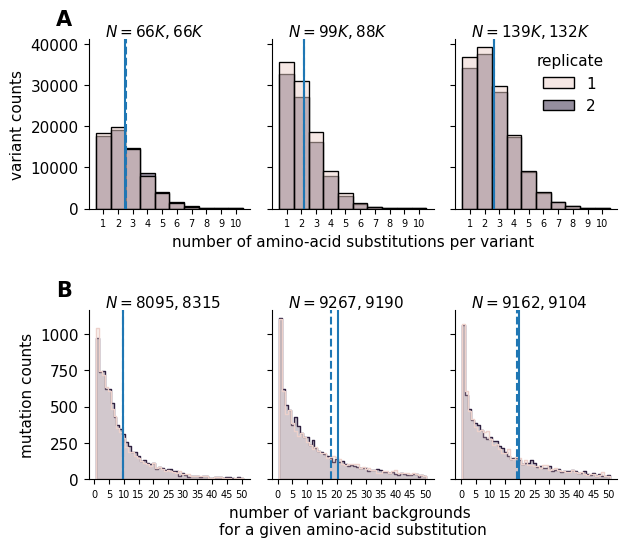

In [21]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.5])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    df = condition_df.query("aa_substitutions != ''")
    df = df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in df.aa_substitutions
        ]
    )
    
    sns.histplot(df.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['num_muts'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
    
    if logscale: iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))//1000
    n_rep2 = len(df.query("replicate == 2"))//1000
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}K, {n_rep2}K$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=7,
        rotation=0
    )
    sns.despine(ax=iter_ax)

row = 1
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(
        df.query("count <= 50"), 
        x="count", 
        ax=iter_ax, 
        element='step', 
        hue="replicate", 
        discrete=True
    )
    
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['count'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
        
    iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))
    n_rep2 = len(df.query("replicate == 2"))
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}, {n_rep2}$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"mutation counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
    xticks = [i for i in range(0, 51) if i % 5 == 0]
    iter_ax.set_xticks(
        xticks,
        labels=xticks, 
        ha="center",
        size=7,
        rotation=0
    )
    
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

fig.subplots_adjust(hspace=.6)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of Replicate Functional Scores

In [22]:
collapsed_bc_df

,replicate,condition,aa_substitutions,func_score,n_subs
0,1,Delta,,-0.136373,0.0
1,1,Delta,A1015D,-1.737700,1.0
2,1,Delta,A1015D E1188Q,-1.641850,2.0
3,1,Delta,A1015D T1027S,-3.116300,2.0
4,1,Delta,A1015T,-1.233350,1.0
...,...,...,...,...,...
308510,2,Omicron_BA2,Y91T T553I,-3.375950,2.0
308511,2,Omicron_BA2,Y91V A1078S,-2.483250,2.0
308512,2,Omicron_BA2,Y91V S112N M177K L335P N405A C671R K679R T859A...,-3.500000,9.0
308513,2,Omicron_BA2,Y91V S98Y D138* Y144V N280D N405P P463S S982R ...,-2.407900,9.0


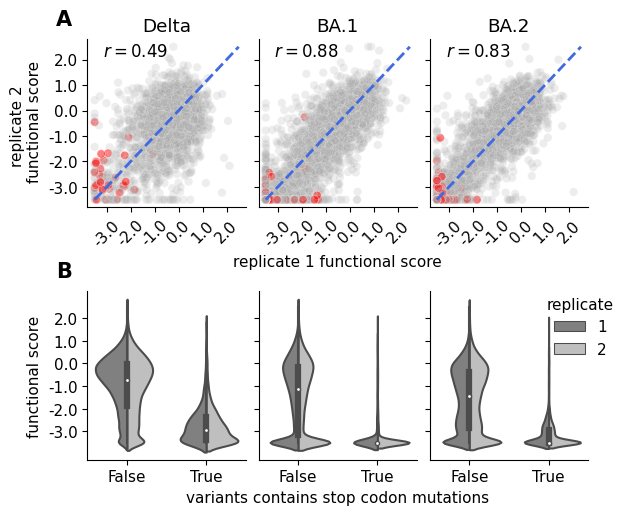

In [23]:
# move rug plot = 
# https://stackoverflow.com/questions/55066869/matplotlib-seaborn-how-to-plot-a-rugplot-on-the-top-edge-of-x-axis
# distributions


saveas = "replicate_functional_score_correlation_scatter"
pal = sns.color_palette('tab20')

fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.3])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
collapsed_bc_df = collapsed_bc_df.assign(
    is_stop=[True if "*" in aasubs else False for aasubs in collapsed_bc_df.aa_substitutions]
)

is_stop_alpha_dict = {
    True : 0.5,
    False : 0.2
}

lim = [-3.8, 2.8]
ticks = np.linspace(-3, 2, 6)
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    
    row = 0
    iter_ax = ax[row, col]
    
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    
    df = df.assign(
        is_stop=[True if "*" in aasubs else False for aasubs in df.index.values]
    )
    df = df.assign(
        n_subs=[len(aasubs.split()) for aasubs in df.index.values]
    )
    
    alpha = [is_stop_alpha_dict[istp] for istp in df.is_stop]
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=alpha,
        hue="is_stop",
        hue_order=[False, True],
        palette=["darkgrey", "red"]
    )
    
    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.set_xticks(ticks, labels=ticks, rotation=45)
    
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    row = 1
    iter_ax = ax[row, col]
    sns.violinplot(
        condition_df,
        x="is_stop",
        y="func_score",
        hue="replicate",
        split=True,
        palette=["0.5", "0.75"],
        ax=iter_ax
    )
    
    sns.despine(ax=iter_ax)
    if col != 2:
        iter_ax.get_legend().remove()
    else:
        iter_ax.legend(bbox_to_anchor = (1.25, 1.05), title="replicate")
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("replicate 2 \n functional score")

ax[0,1].set_xlabel("replicate 1 functional score")
ax[0,1].set_title("BA.1")
ax[0,2].set_xlabel("")
ax[0,2].set_title("BA.2")

ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("functional score")

ax[1,1].set_xlabel("variants contains stop codon mutations")
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("")
ax[1,1].set_ylabel("")

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace = 0.5)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Convergence Analysis

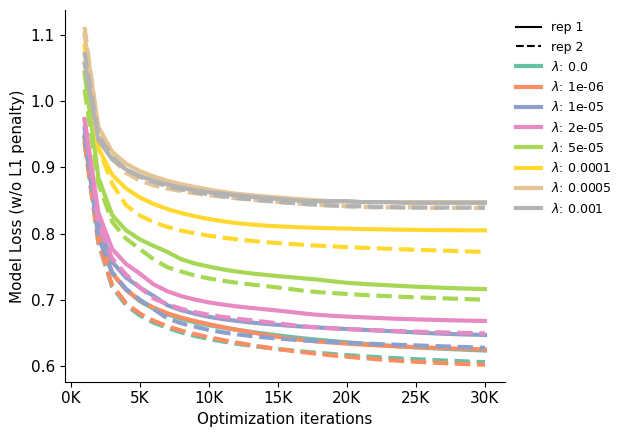

In [24]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )
# labels = ax.get_xticklabels()[1:-1]
# print(labels)
# lebels = [f"{int(l)//1000}K" for l in labels]
ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)

# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shrinkage Analysis

In [25]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    mut_df.rename(
        {
            bc : f"{bc}_Omicron_BA1"
            for bc in mut_df.columns
            if "beta" in bc
        }, 
        axis=1, 
        inplace=True
    )
#     break
# mut_df


    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if ("_S_" in col or "beta" in col) and "avg" not in col
        ],
        value_name="S"
    )
#     break
# mut_df
    
    mut_df = mut_df.assign(
        scale_coeff_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "nonsynonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,scale_coeff_lasso,sense,condition,replicate
0,M1I,-3.260941,0.0,nonsynonymous,Omicron_BA1,0
1,F2I,0.122912,0.0,nonsynonymous,Omicron_BA1,0
2,F2L,0.470533,0.0,nonsynonymous,Omicron_BA1,0
3,F2S,0.258484,0.0,nonsynonymous,Omicron_BA1,0
4,F2V,0.920090,0.0,nonsynonymous,Omicron_BA1,0
...,...,...,...,...,...,...
155419,S1252T,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155420,S1252V,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155421,S1252W,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155422,S1252Y,-0.000000,0.001,nonsynonymous,Omicron_BA2,1


In [26]:
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data, **kwargs)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference:
            

            if np.all(muts_df_inner[f"0_beta"] <= 0.05) or np.all(muts_df_inner[f"1_beta"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_beta"], muts_df_inner[f"1_beta"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_beta", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_beta"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            

        else:
            if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
#             if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-stop-sparsity,Delta-0-nonsynonymous-sparsity,Delta-1-stop-sparsity,Delta-1-nonsynonymous-sparsity,Omicron_BA1-replicate-correlation,Omicron_BA1-replicate-correlation-interval,Omicron_BA1-0-stop-sparsity,...,Omicron_BA2-0-stop-sparsity,Omicron_BA2-0-nonsynonymous-sparsity,Omicron_BA2-1-stop-sparsity,Omicron_BA2-1-nonsynonymous-sparsity,Delta-0-loss,Omicron_BA1-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA1-1-loss,Omicron_BA2-1-loss
0,0.0,0.554929,"tuple[0.5370964978985913, 0.5722648986501958]",0.000000,0.000000,0.000000,0.000000,0.930213,"tuple[0.9267077900747744, 0.9335555876422115]",0.0,...,0.000000,0.000000,0.000000,0.000000,0.20882076205032926,0.22789180399101802,0.18664733664308814,0.24506442143971263,0.18465566536826694,0.1760694236269004
1,1e-06,0.573597,"tuple[0.5562993136440083, 0.5903975753688284]",1.058201,1.062118,2.358491,1.612388,0.931465,"tuple[0.9280207702838509, 0.9347500486742599]",0.0,...,2.645503,2.043772,3.301887,2.538314,0.2095801899892468,0.2280875893955353,0.18732690364137838,0.24470831892525705,0.18108420346631426,0.17597020957958107
2,1e-05,0.664096,"tuple[0.6496527952209529, 0.6780609364839632]",42.857143,14.531703,36.792453,15.692848,0.931760,"tuple[0.9283298103293437, 0.9350311703975887]",0.0,...,54.497354,22.610235,55.188679,21.695402,0.21712778568637822,0.23531437758381926,0.19444945622000653,0.25432472750856117,0.18987429899848507,0.18334323651068812
3,2e-05,0.692708,"tuple[0.6792574701745838, 0.7056933606407964]",79.894180,25.474734,73.113208,26.963602,0.927198,"tuple[0.9235476681576391, 0.930680097702718]",0.0,...,87.301587,39.588027,87.735849,38.074713,0.22445927747438593,0.2425961013490243,0.20096684081808935,0.26299422961432173,0.1969208688038345,0.1893664938717848
4,5e-05,0.699526,"tuple[0.6863186029652781, 0.7122722270788485]",97.883598,48.181526,96.698113,49.568966,0.917820,"tuple[0.9137205688259998, 0.9217324894906378]",0.0,...,99.470899,64.435146,99.528302,62.021073,0.24213011826465483,0.2611316537893592,0.21288153288295714,0.2837855560280358,0.2162351184540399,0.20015619585673422
5,0.0001,0.670030,"tuple[0.6557884109130815, 0.6837944044772347]",100.000000,91.422594,100.000000,83.205619,0.915030,"tuple[0.9107982279932924, 0.9190700416444924]",0.0,...,100.000000,93.723849,100.000000,87.915070,0.2770587709896654,0.2971002289750148,0.2308249931522797,0.30993203770406796,0.2466480885122338,0.2158364215848458
6,0.0005,NaN,NaN,100.000000,100.000000,100.000000,100.000000,0.910136,"tuple[0.9056726147263224, 0.9143984410059197]",0.0,...,100.000000,99.983907,100.000000,99.984036,0.29546649983190093,0.30793628224864517,0.24423537588069633,0.3353658149276702,0.2663713488090842,0.23718472964055182
7,0.001,NaN,NaN,100.000000,100.000000,100.000000,100.000000,0.909570,"tuple[0.9050797701373341, 0.9138579589552435]",0.0,...,100.000000,100.000000,100.000000,100.000000,0.2952379991468209,0.30723660253500723,0.24405511186938336,0.3357127147863088,0.2663125506383004,0.23733334115837154


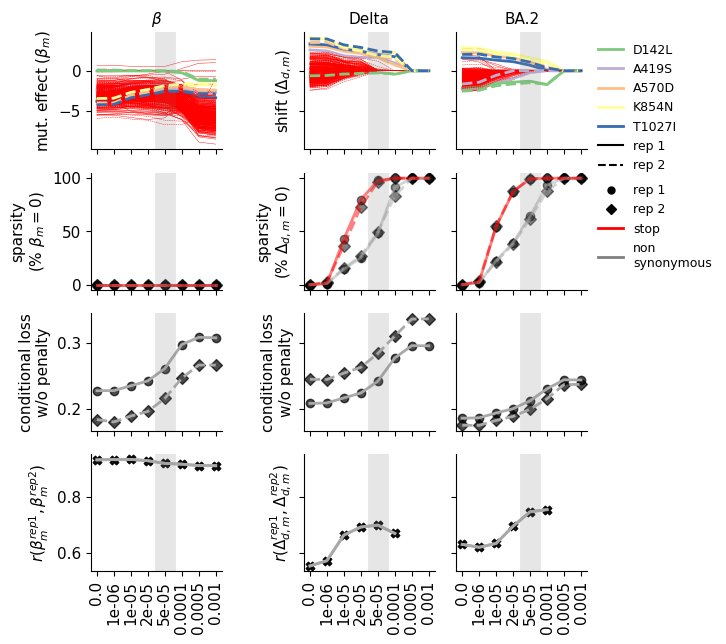

In [27]:
# call percent - > "fraction"
# Change lambda to whatever we decide for the lexicon

saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    4,4, 
    figsize=[6.4,7],
    sharex=True, 
    sharey='row',
    gridspec_kw={
        'width_ratios': [1,0.3,1,1]
#         'height_ratios' : []
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Omicron_BA1" : 0,
    "Delta" : 2,
    "Omicron_BA2" : 3
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.3
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
#     # plot nonsynonymous, non validated
#     for mut, trace_df in df.query(
#         "sense == 'nonsynonymous' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.scale_coeff_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['nonsynonymous'],
#             alpha=sense_alpha['nonsynonymous'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title(r"$\beta$", size=11)
ax[0, 2].set_title("Delta", size=11)
ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)
ax[3, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("conditional loss\nw/o penalty", size=11)
ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("conditional loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)

ax[3, 2].set_ylabel("$r(\Delta_{d,m}^{rep1},\Delta_{d,m}^{rep2})$", size=11)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non\nsynonymous')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=90, ha='center')
ax[3,2].set_xticks(ax[3,2].get_xticks(), ax[3,2].get_xticklabels(), rotation=90, ha='center')
ax[3,3].set_xticks(ax[3,3].get_xticks(), ax[3,3].get_xticklabels(), rotation=90, ha='center')

ax[3,1].set_xlabel(f"lasso regularization strength ($\lambda$)")
ax[3,1].xaxis.set_label_coords(1.1, -.5)

# plt.tight_layout()




# fig.subplots_adjust(hspace=0.1, wspace=0.05)


# ax[0,0].text(
#     -0.3, 1.00, 
#     f"A", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[0,0].transAxes
# )
# ax[1,0].text(
#     -0.3, 1.00, 
#     f"B", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[1,0].transAxes
# )
# ax[2,0].text(
#     -0.3, 1.00, 
#     f"C", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[2,0].transAxes
# )
# ax[3,0].text(
#     -0.3, 1.00, 
#     f"D", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[3,0].transAxes
# )

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

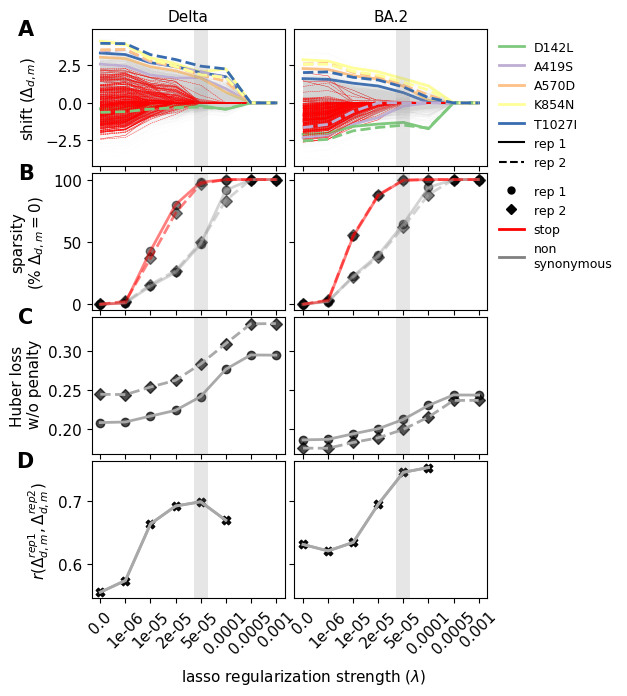

In [28]:
# call percent - > "fraction"
# Change lambda to whatever we decide for the lexicon

saveas="shrinkage_analysis_trace_plots"
fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.3
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    if condition == "Omicron_BA1" : continue
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous' & not mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)

ax[0, 0].set_title("Delta", size=11)
ax[0, 1].set_title("BA.2", size=11)

ax[0, 0].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
ax[2, 0].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[3, 0].set_ylabel("$r(\Delta_{d,m}^{rep1},\Delta_{d,m}^{rep2})$", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non\nsynonymous')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=45, ha='center')
ax[3,1].set_xticks(ax[3,1].get_xticks(), ax[3,1].get_xticklabels(), rotation=45, ha='center')

ax[3,0].set_xlabel(f"lasso regularization strength ($\lambda$)")
ax[3,0].xaxis.set_label_coords(1.1, -.5)

plt.tight_layout()




fig.subplots_adjust(hspace=0.05, wspace=0.05)


ax[0,0].text(
    -0.3, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.3, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.3, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.3, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Comparison of reference choice

In [29]:
ref_com_model_set = "../results/reference_comparison"
ref_com_models = pickle.load(open(f"{ref_com_model_set}/models.pkl", "rb"))
ref_com_models

,dataset,δ_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate,reference
0,<multidms.data.Data object at 0x7f02c4...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.2202068786736577, 0.9957886415795965, 0.915...",<multidms.model.Model object at 0x7ef0...,1,Delta
1,<multidms.data.Data object at 0x7ef020...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.1942817009461835, 0.9723563856922917, 0.905...",<multidms.model.Model object at 0x7f04...,2,Delta
2,<multidms.data.Data object at 0x7ef013...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0431130631724885, 0.8851882580641597, 0.828...",<multidms.model.Model object at 0x7ef0...,1,Omicron_BA1
3,<multidms.data.Data object at 0x7ef012...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0182329451518013, 0.8750387383519955, 0.817...",<multidms.model.Model object at 0x7ef0...,2,Omicron_BA1
4,<multidms.data.Data object at 0x7ef011...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.009825506220528, 0.858498746562619, 0.81979...",<multidms.model.Model object at 0x7ef0...,1,Omicron_BA2
5,<multidms.data.Data object at 0x7ef010...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[0.9973539088743184, 0.8560805451049357, 0.796...",<multidms.model.Model object at 0x7ef0...,2,Omicron_BA2


In [30]:
relative_params = pd.DataFrame()
homologs = ["Delta", "Omicron_BA1", "Omicron_BA2"]

# For each respective model fit 
for reference, replicate_models in ref_com_models.groupby("reference"):
    
    # combine the replicate mutational 
    mut_df = multidms.utils.combine_replicate_muts(
        {
            f"rep_{row.replicate}":row["model_30000"] 
            for idx, row in replicate_models.iterrows()
        },
        times_seen_threshold = 1
    )
    
    mut_df = mut_df.copy()[[c for c in mut_df.columns if "avg" in c]]
    
    # Compute mut effect (beta+shift) relative to each homolog
    for homolog in homologs:
        if homolog == reference:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"]
        else:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"] + mut_df[f"avg_S_{homolog}"]
       
    # Compute shifts relative to BA1 (betas_h - beta_BA1)
    for homolog in homologs:
        mut_df[f"S_{homolog}"] = mut_df[f"beta_{homolog}"] - mut_df[f"beta_Omicron_BA1"]
    
    # drop un-neccessary columns
    mut_df.drop([c for c in mut_df.columns if "avg" in c], axis=1, inplace=True)
    
    mut_df = mut_df.assign(reference = reference)
    
    relative_params = pd.concat([relative_params, mut_df])

    
relative_params.drop(["beta_Delta", "beta_Omicron_BA2", "S_Omicron_BA1"], axis=1, inplace=True)
relative_params.reference.replace({"Omicron_BA2":"BA2", "Omicron_BA1": "BA1"}, inplace=True)
relative_params

,beta_Omicron_BA1,S_Delta,S_Omicron_BA2,reference
mutation,,,,
M1I,-3.392746,0.000000,0.000000,Delta
F2L,0.228677,0.000000,-0.064132,Delta
F2S,0.143352,0.000000,0.000000,Delta
F2V,0.314621,0.000000,0.000000,Delta
V3A,-0.054190,-0.014244,-0.014244,Delta
...,...,...,...,...
S1252T,-0.152548,-0.028114,-0.028114,BA2
S1252V,0.151697,0.025453,-0.061956,BA2
S1252W,0.181581,0.000000,0.000000,BA2


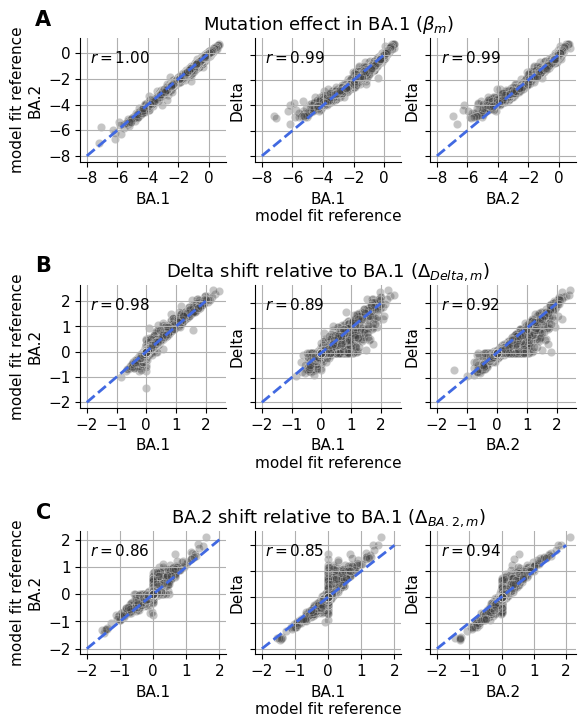

In [31]:
saveas = "reference_model_comparison_params_scatter"
parameters = ["beta_Omicron_BA1", "S_Delta", "S_Omicron_BA2"]


fig = plt.figure( figsize=[6.4, 8])
axs = fig.subplot_mosaic(
    [[f"{param}_{col}" for col in range(3)] for param in parameters],
#     empty_sentinel="."
#     height_ratios=[],
#     width_ratios=[],
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 1.0,
    }
)

param_limits = {
    "beta_Omicron_BA1" : range(-8, 2, 2),
    "S_Delta" : range(-2, 3),
    "S_Omicron_BA2" : range(-2, 3) 
}

param_titles = {
    "beta_Omicron_BA1" : r"Mutation effect in BA.1 ($\beta_m$)",
    "S_Delta" : "Delta shift relative to BA.1 ($\Delta_{Delta,m}$)",
    "S_Omicron_BA2" : "BA.2 shift relative to BA.1 ($\Delta_{BA.2,m}$)"
}


for row, param in enumerate(parameters):
    
    # pivot to each fit on columns, drop NIS.
    data = relative_params.pivot(
        columns = "reference",
        values = param
    ).dropna()

    # plot each combination of fits
    for col, (x, y) in enumerate(combinations(data.columns, 2)):
        iter_ax = axs[f"{param}_{col}"]
        
        sns.scatterplot(
            data = data,
            x = x,
            y = y,
            ax = iter_ax,
            alpha=0.3,
            c='0.25'
        )
        
        corr = pearsonr(data[x], data[y])[0]
        iter_ax.annotate(
            f"$r = {corr:.2f}$", 
            (0.07, 0.8), 
            xycoords="axes fraction", 
            fontsize=11
        )
        
        limits = param_limits[param]
        iter_ax.set_yticks(limits)
        iter_ax.set_xticks(limits)
        mmin, mmax = min(limits), max(limits)
        iter_ax.plot([mmin, mmax], [mmin, mmax], "--", lw=2, c="royalblue")
        label_fn = lambda x: x if x == "Delta" else f"{x[0]}{x[1]}.{x[2]}"
        
        
        xl = f"{label_fn(x)}"
        yl = f"{label_fn(y)}"
        if col == 1: xl += "\nmodel fit reference"
        if col == 0: yl = "model fit reference\n" + yl
        iter_ax.set_xlabel(xl)
        iter_ax.set_ylabel(yl)            
            
        
        
        iter_ax.grid()
        sns.despine(ax = iter_ax)
        
        if col != 0:
            iter_ax.tick_params("y", labelleft=False)
            
        if col == 1:
            iter_ax.set_title(param_titles[param], size=13)
            


for param, sub_anno in zip(parameters, ["A", "B", "C"]):
    iter_ax = axs[f"{param}_0"]    
    axs[f"{param}_0"].text(
        -0.2, 1.15, 
        sub_anno, 
        ha="right", va="center", 
        size=15,
        weight="bold",
        transform=iter_ax.transAxes
    )

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Global Epistasis Fits

In [32]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():    
     
    model = replicate_row[model_name]
    df = model.variants_df
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(df.corrected_func_score, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)
    params = model.get_condition_params(model.data.reference)
    latent_preds = model._model_components["g"](params["α"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   
    
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

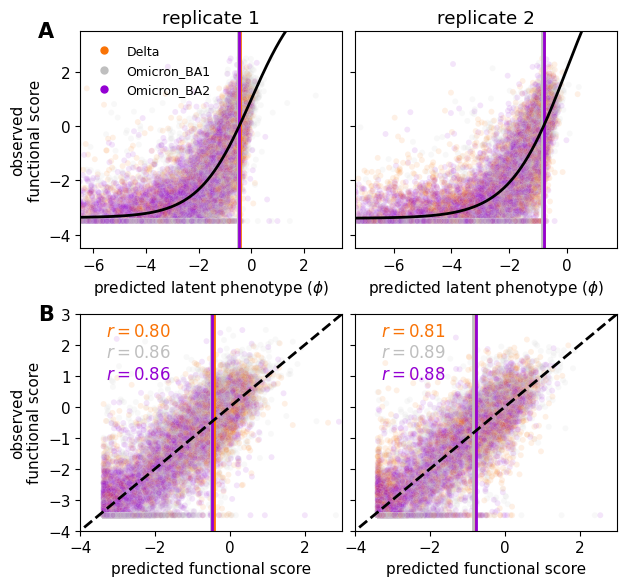

In [33]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.2),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"replicate {replicate+1}")
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    
    iter_ax.plot([ylb, yub], [ylb, yub], "k--", lw=2)
    iter_ax.set_xlim([-4, 3])
    iter_ax.set_ylim([-4, 3])
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["corrected_func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()


## Percent Shifts Under X

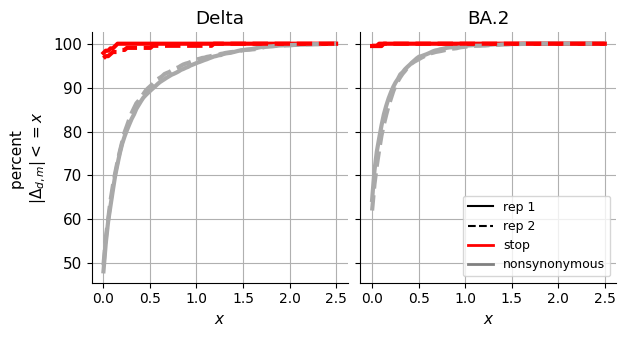

In [34]:


# separate the deletions

saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("scale_coeff_lasso == '5e-05' & condition != 'Omicron_BA1'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 3
    )
    iter_ax.set_xticks(np.linspace(0,2.5,6),np.linspace(0,2.5,6), rotation=0, ha="center",size=10)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("BA.2")

ax[0].set_ylabel("percent \n$|\Delta_{d,m}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [35]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=1,
    how="inner"
)
mut_df_replicates

,wts,sites,muts,0_beta,1_beta,avg_beta,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
M1I,M,1,I,-3.045022,-4.064633,-3.554828,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
F2L,F,2,L,0.185108,0.207384,0.196246,-0.000000,-0.000000,0.000000,-0.202338,0.000000,-0.101169
F2S,F,2,S,0.184990,-0.070937,0.057026,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
F2V,F,2,V,0.204916,-0.060744,0.072086,-0.000000,-0.000113,-0.000057,0.000000,0.000000,0.000000
V3A,V,3,A,-0.013152,-0.042563,-0.027858,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.135954,-0.188259,-0.162106,-0.000000,0.000000,0.000000,-0.059405,-0.000000,-0.029702
S1252V,S,1252,V,0.154888,0.173735,0.164311,0.251570,-0.180085,0.035742,-0.035982,-0.106844,-0.071413
S1252W,S,1252,W,0.104411,0.262528,0.183470,0.000000,0.000000,0.000000,0.000000,-0.030140,-0.015070


In [36]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates["sense"] = [
    "stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts
]

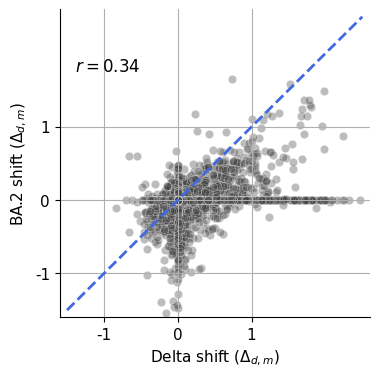

In [37]:
data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
lim = [-1.6, 2.6]
ticks = range(-1, 2)
sns.scatterplot(
    data=data,
    x="avg_S_Delta",
    y="avg_S_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(data["avg_S_Delta"], data["avg_S_Omicron_BA2"])[0]
ax.annotate(
    f"$r = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylim(lim)
ax.set_xlim(lim)
ax.set_yticks(ticks, labels=ticks)
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel("BA.2 shift ($\Delta_{d,m}$)")
ax.set_xlabel("Delta shift ($\Delta_{d,m}$)")
# ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

Note that we're plotting the average. that's why less correlation between delta shifts makes the density of stop so much smaller for Delta

## Comparison to Naive approach

In [38]:
naive_model_set = "../results/naive_approach/"
naive_models = pickle.load(open(f"{naive_model_set}/models.pkl", "rb"))
naive_models

,dataset,δ_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_3000,replicate,condition
0,<multidms.data.Data object at 0x7ef01a...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.31203029678950295, 0.23625210580935888, 0.2...",<multidms.model.Model object at 0x7f03...,0,Delta
3,<multidms.data.Data object at 0x7f02c4...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2948697926675047, 0.25160339956684513, 0.24...",<multidms.model.Model object at 0x7ef0...,1,Delta
1,<multidms.data.Data object at 0x7ef022...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.24738580498232596, 0.22392991691351716, 0.2...",<multidms.model.Model object at 0x7f03...,0,Omicron_BA1
4,<multidms.data.Data object at 0x7ef01b...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2016639589109823, 0.1772295498722254, 0.172...",<multidms.model.Model object at 0x7f03...,1,Omicron_BA1
2,<multidms.data.Data object at 0x7f0308...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2159512679704268, 0.19288537791487242, 0.18...",<multidms.model.Model object at 0x7f03...,0,Omicron_BA2
5,<multidms.data.Data object at 0x7f0300...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.20598509065865622, 0.18326607028080533, 0.1...",<multidms.model.Model object at 0x7f03...,1,Omicron_BA2


In [39]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in naive_models.iterrows()}
naive_mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)
naive_mut_df

,wts,sites,muts,0-Delta_beta,1-Delta_beta,0-Omicron_BA1_beta,1-Omicron_BA1_beta,0-Omicron_BA2_beta,1-Omicron_BA2_beta,avg_beta
mutation,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174
...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637


In [40]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [0, 1]:
        reference_betas = naive_mut_df[f"{replicate}-{reference}_beta"]
        condition_betas = naive_mut_df[f"{replicate}-{condition}_beta"]
        naive_mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
naive_mut_df

,wts,sites,muts,0-Delta_beta,1-Delta_beta,0-Omicron_BA1_beta,1-Omicron_BA1_beta,0-Omicron_BA2_beta,1-Omicron_BA2_beta,avg_beta,0-Delta_S,1-Delta_S,0-Omicron_BA2_S,1-Omicron_BA2_S
mutation,,,,,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281,2.207859,0.066455,-0.293432,-1.098140
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214,0.292775,0.421879,-0.788579,-0.243856
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129,0.026161,-0.052943,-0.138430,-0.141601
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189,0.053870,0.733991,0.039044,0.118434
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174,-0.320647,0.766147,0.071591,-0.082263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227,0.741787,-0.186620,0.360278,0.052571
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042,-0.005918,-0.366670,-0.327992,-0.191334
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637,0.074058,-0.482561,-0.058071,-0.342390


In [41]:
# saveas = "naive_approach_replicate_shifts_correlation"

# fig, ax = plt.subplots(1,3, figsize=[7,3.5], sharex=True, sharey=True)
# lim = [-8, 11]
# ticks = np.linspace(-7, 11, 7)

# for i, condition in enumerate(["Omicron_BA1", "Omicron_BA2"]):
#     iter_ax = ax[i]
#     sns.scatterplot(
#         naive_mut_df, 
#         x=f"0-{condition}_S", 
#         y=f"1-{condition}_S", 
#         ax=iter_ax,
#         alpha=0.3,
#         c='0.25'
#     )
#     iter_ax.set_ylim(lim)
#     iter_ax.set_xlim(lim)
#     iter_ax.set_xticks(ticks, labels=ticks)
#     iter_ax.set_yticks(ticks, labels=ticks)
#     iter_ax.plot([-8, 12], [-8, 12], "--", lw=2, c="royalblue")
    
#     corr = pearsonr(naive_mut_df[f"0-{condition}_S"], naive_mut_df[f"1-{condition}_S"])[0]
# #     sns.scatterplot(mut_df, x=f"0-{condition}_S", y=f"1-{condition}_S", ax=ax[i], alpha=0.25)
#     ax[i].annotate(
#         f"$r = {corr:.2f}$", 
#         (0.1, 0.8), 
#         xycoords="axes fraction", 
#         fontsize=12
#     )
#     iter_ax.grid()
#     sns.despine(ax=iter_ax)

# condition = reference
# iter_ax = ax[2]
# sns.scatterplot(
#     naive_mut_df, 
#     x=f"0-{condition}_beta", 
#     y=f"1-{condition}_beta", 
#     ax=iter_ax,
#     alpha=0.3,
#     c='0.25'
# )
# iter_ax.set_ylim(lim)
# iter_ax.set_xlim(lim)
# iter_ax.set_xticks(ticks, labels=ticks)
# iter_ax.set_yticks(ticks, labels=ticks)
# iter_ax.plot([-8, 12], [-8, 12], "--", lw=2, c="royalblue")

# corr = pearsonr(naive_mut_df[f"0-{condition}_beta"], naive_mut_df[f"1-{condition}_beta"])[0]
# #     sns.scatterplot(mut_df, x=f"0-{condition}_S", y=f"1-{condition}_S", ax=ax[i], alpha=0.25)
# iter_ax.annotate(
#     f"$r = {corr:.2f}$", 
#     (0.1, 0.8), 
#     xycoords="axes fraction", 
#     fontsize=12
# )
# iter_ax.grid()
# sns.despine(ax=iter_ax)

# #     ax[0].set_xlabel("replicate 1")
# #     ax[0].set_ylabel("replicate 2")
    
    
# # ax[0].set_title("Delta")
# # ax[0].set_xlabel("replicate 1")
# # ax[0].set_ylabel("replicate 2")
# # ax[1].set_title("BA.2")
# # ax[1].set_xlabel("replicate 1")

# plt.tight_layout()
# # fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
# # fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
# plt.show()

## Betas and Shifts (Distributions and Correlations)

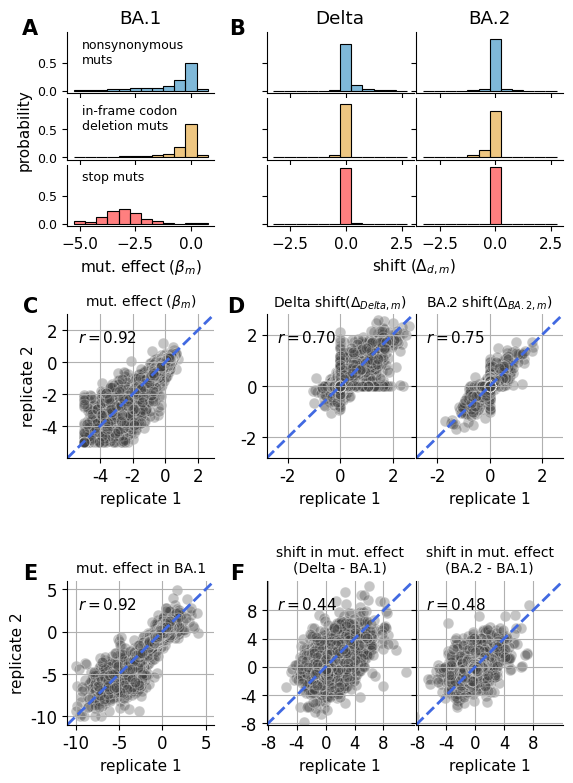

In [44]:
# data = mut_df_replicates.copy()
saveas="shift_distribution_correlation_naive"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_beta"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["S_Delta", "S_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_beta"]*dist_sf+ ["."]
for param in ["S_Delta", "S_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)
    
# niave correlation plot row
naive_corr_row = ["naive_corr_Omicron_BA1_beta"]*dist_sf+ ["."]
for param in ["Delta_S", "Omicron_BA2_S"]:
    naive_corr_row.extend([f"naive_corr_{param}"]*dist_sf)

# shift and effect plot
# se_row_wc = ["se_S_Delta"]*4  + ["se_S_Omicron_BA2"]*4 + ["cbar"] + ["."]

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, naive_corr_row],
    height_ratios=[0.3, 0.3, 0.3] + [0.38, 0.7, 0.55, 0.7],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "beta" : np.arange(-5.25, 1.0, 0.5),
    "S_Delta" : np.arange(-3.25, 3.25, 0.5),
    "S_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
df = mut_df_replicates.copy()
df["avg_beta"].clip(lower=-5, inplace=True)

for col, param in enumerate(["beta", "S_Delta", "S_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            df.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="stop",
            color="red" if mut_type == "n" else pal.as_hex()[row],
#             color="lightgrey",
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_yticks(
            [0.0, 0.5], [0.0, 0.5], rotation=0, ha="right",size=9
        )
#         else:
#             iter_ax.set_yticks(
#                 [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
#             )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        else:
            iter_ax.set_ylabel("probability")
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
# axs[].set_title("")
axs["dist_n_beta"].set_xlabel(r"mut. effect $(\beta_{m})$")
axs["dist_n_beta"].xaxis.set_label_coords(0.5, -.5)


axs["dist_m_beta"].text(
    0.1, 0.9, 
    f"nonsynonymous\nmuts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_beta"].transAxes
)
axs["dist_i_beta"].text(
    0.1, 0.9, 
    f"in-frame codon\ndeletion muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_beta"].transAxes
)
axs["dist_n_beta"].text(
    0.1, 0.9, 
    f"stop muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_beta"].transAxes
)

axs["dist_n_S_Delta"].set_xlabel('shift ($\Delta_{d,m}$)')
axs["dist_n_S_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_S_Delta"].set_title("Delta")
axs["dist_m_S_Omicron_BA2"].set_title("BA.2")


#################
# CORRELATIONS
#################

data = mut_df_replicates.dropna().copy()
data['0_beta'].clip(lower=-5, inplace=True)
data['1_beta'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["beta", "S_Delta", "S_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"0_{param}"], data[f"1_{param}"]
    sns.scatterplot(
        data = data,
        x = f"0_{param}",
        y = f"1_{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-2.8, 2.8]
        ticks = [-2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-6, 3]
        ticks = [-4, -2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)
    
#################
# NAIVE CORRELATIONS
#################

# data = mut_df_replicates.dropna().copy()
# data['0_beta'].clip(lower=-5, inplace=True)
# data['1_beta'].clip(lower=-5, inplace=True)

data = naive_mut_df.dropna().copy()
data["0-Omicron_BA1_beta"].clip(lower=-10, inplace=True)
data["1-Omicron_BA1_beta"].clip(lower=-10, inplace=True)

# plot the correlations of parameters
for col, param in enumerate(["Omicron_BA1_beta", "Delta_S", "Omicron_BA2_S"]):
    iter_ax = axs[f"naive_corr_{param}"]
    x, y = data[f"0-{param}"], data[f"1-{param}"]
    sns.scatterplot(
        data = data,
        x = f"0-{param}",
        y = f"1-{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-8.2, 12.2]
        ticks = range(-8, 12, 4)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-11, 6]
        ticks = range(-10, 6, 5)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)




# Add subpanel labels
axs["dist_m_beta"].text(
    -0.2, 1.05, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_beta"].transAxes
)


axs["dist_m_S_Delta"].text(
    -0.15, 1.05, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_S_Delta"].transAxes
)

axs["corr_beta"].text(
    -0.2, 1.05, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_beta"].transAxes
)

axs["corr_S_Delta"].text(
    -0.15, 1.05, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_S_Delta"].transAxes
)

axs["naive_corr_Omicron_BA1_beta"].text(
    -0.2, 1.05, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Omicron_BA1_beta"].transAxes
)

axs["naive_corr_Delta_S"].text(
    -0.15, 1.05, 
    f"F", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Delta_S"].transAxes
)



# titles
axs["dist_m_beta"].set_title("BA.1")
axs["corr_beta"].set_title(r"mut. effect $(\beta_{m})$", size=10)
axs["corr_S_Delta"].set_title("Delta shift($\Delta_{Delta, m}$)", size=10)
axs["corr_S_Omicron_BA2"].set_title("BA.2 shift($\Delta_{BA.2, m}$)", size=10)

# axs["naive_corr_Omicron_BA1_beta"].set_title(r"$\beta_{m}^{BA.1}$")
axs["naive_corr_Omicron_BA1_beta"].set_title("mut. effect in BA.1", size=10)
# axs["naive_corr_Delta_S"].set_title(r"$\beta_{m}^{Delta} - \beta_{m}^{BA.1}$")
axs["naive_corr_Delta_S"].set_title("shift in mut. effect\n(Delta - BA.1)", size=10)
axs["naive_corr_Omicron_BA2_S"].set_title("shift in mut. effect\n(BA.2 - BA.1)", size=10)
# axs["naive_corr_Omicron_BA2_S"].set_title(r"$\beta_{m}^{BA.2} - \beta_{m}^{BA.1}$")

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')

plt.show()  

In [44]:
mut_df_replicates.query(
    "muts == '-'"
).sort_values(
    by="avg_S_Omicron_BA2"
)[["wts","sites", "muts", "avg_S_Omicron_BA2"]].head(10)

,wts,sites,muts,avg_S_Omicron_BA2
mutation,,,,
N164-,N,164.0,-,-1.277435
A163-,A,163.0,-,-1.110813
V159-,V,159.0,-,-1.085341
S162-,S,162.0,-,-1.072458
L241-,L,241.0,-,-0.824015
N137-,N,137.0,-,-0.808478
Y160-,Y,160.0,-,-0.661097
T63-,T,63.0,-,-0.658963
C136-,C,136.0,-,-0.657519


## Shifted Mutations, Heat and Sitemap

In [52]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]

In [ ]:
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)

In [ ]:
mut_df_replicates

In [ ]:
site_map = model.data.site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

In [ ]:
site_map

In [ ]:
site_map.to_csv("../results/site_map.csv", index=True)

In [ ]:
mut_df_replicates

In [ ]:
mut_df_replicates

In [ ]:
mut_df_replicates.info()

In [ ]:
## xlabel = sites
## captilaization
# add sites to the second heatmap
## indicate deletions along with N.I.S (check to make sure you're capturing all nis)

# make interactive heatmap and send link to where folks can find that.

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}


# Plot per-site metric
metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
# metric_prefix = 'sumdS_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
#     sns.scatterplot(
#         x='sites', 
#         y=f'{metric_prefix}{homolog}',
#         data=shifts_by_site, 
#         s=15,
#         ax=axs[homolog], 
#         color=cs[homolog],
#         label=""
#     )

    sns.scatterplot(
        x='sites', 
        y=f'avg_S_{homolog}',
        data=mut_df_replicates, 
        s=15,
        alpha=0.7,
        edgecolor="grey",
        linewidth=0.05,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
#     nis = shifts_by_site.query(f"not is_{homolog}_wt")
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(2.9, len(nis)),
        data=nis, 
        s=30,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="k"
    )

    
    
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        ylim=[-2, 3],
        yticks=[-2, -1, 0, 1, 2],
#         ylabel=homolog,/
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].set_ylabel('shift ($\Delta_{d,m}$)', size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -2), site_j-site_i+11, 4,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_S_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : None
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-2.0,
            vmax=2.0,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
#                 hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
#             axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
#         else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.25, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.035, 1.15, 
    f"Delta", 
    ha="left", va="center", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.035, 1.15, 
    f"BA.2", 
    ha="left", va="center", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Interactive heatmap

In [ ]:
chart = multidms.plot.mut_shift_plot(
    {
        f"rep_{row.replicate}":row[model_name] 
        for idx, row in chosen_replicate_models.iterrows()
    },
    include_beta = False,
    times_seen_threshold=times_seen_threshold
)
chart.save(f"{OUTDIR}/interactive_chart_wo_beta.html")
chart

## Validation Mutations Shift V Titer fold change

In [ ]:
saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.39, 0.7, 0.7
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
#     width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)


#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('../data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
#mutation = 'A570D'
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=10, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops={'visible': False}, #dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 90)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta
    else:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta + mut_df[f"avg_S_{homolog}"]

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('../data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'beta_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=100, alpha=0.7,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
        xlim=[-3.1, 0.5], xticks=[-3, -2, -1, 0]
    )
    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.02, 'inferred latent effect of mutation\n(= $beta_m + \Delta_{d,m}$)',
    ha='center'
)
fig.text(
    0.000, 0.31, 'fold change in viral titer\n (mutant : unmutated)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()